#1. OCR 리뷰

In [1]:
!pip install pytesseract

In [2]:
!apt install tesseract-ocr
!apt install tesseract-ocr-kor

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tesseract-ocr-kor
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 1,052 kB of archives.
After this operation, 1,693 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-kor all 1:4.00~git30-7274cfa-1.1 [1,052 kB]
Fetched 1,052 kB in 1s (1,487 kB/s)
Selecting previously unselected package tesseract-ocr-kor.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-kor_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-kor (1:4.00~git30-7274cfa-1.1) ...
Setting up tesserac

In [3]:
!tesseract --list-langs

List of available languages (3):
eng
kor
osd


- 기본 사용법

In [4]:
import pytesseract
import cv2
import matplotlib.pyplot as plt
import requests
import imutils
import re
import numpy as np
from pytesseract import Output
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours


In [5]:
def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)

    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])

        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

In [11]:
!wget https://raw.githubusercontent.com/ws-l/hh2025/main/data/ocr_test4.jpg

--2025-05-25 20:42:59--  https://raw.githubusercontent.com/ws-l/hh2025/main/data/ocr_test4.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2167317 (2.1M) [image/jpeg]
Saving to: ‘ocr_test4.jpg’

ocr_test4.jpg       100%[===================>]   2.07M  --.-KB/s    in 0.02s   

2025-05-25 20:42:59 (115 MB/s) - ‘ocr_test4.jpg’ saved [2167317/2167317]



In [12]:
path = 'ocr_test4.jpg'
image = cv2.imread(path)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [68]:
#url의 이미지를 직접 읽는 경우
#url = 'https://user-images.githubusercontent.com/69428232/148330274-237d9b23-4a79-4416-8ef1-bb7b2b52edc4.jpg'
#image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
#org_image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR) #rgb포맷

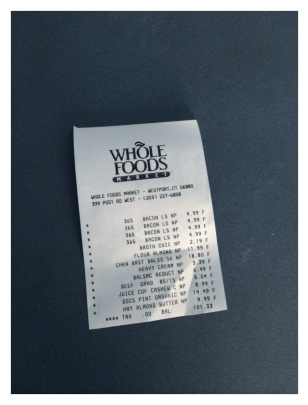

In [72]:
plt.figure(figsize=(8, 5))

plt.subplot(1, 1, 1)
plt.imshow(rgb_image)
plt.xticks([]), plt.yticks([])

plt.show()

In [14]:
text = pytesseract.image_to_string(rgb_image, lang='eng+kor')
print(text)

y - wesTPoRT,CT 06880

yHOLE FOODS NARKE
399 post RD WEST 7 ;

903) 227-6858

pAcoN LS NP
pacon LS N

BACON LS NP
pacon tS N

365

 



In [15]:
org_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)  #open cv의 기본 이미지 포맷은 BGR로 변환

In [16]:
image = org_image.copy()
image = imutils.resize(image, width=500)
ratio = org_image.shape[1] / float(image.shape[1])

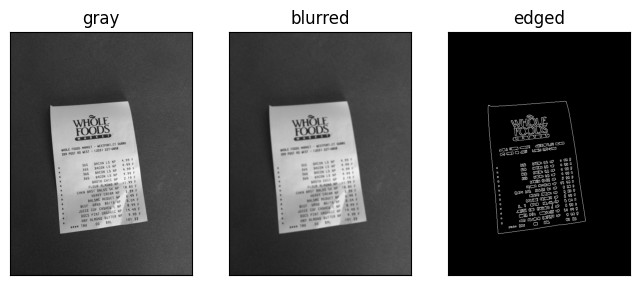

In [17]:
# 이미지를 grayscale로 변환하고 blur를 적용 / 모서리를 찾기위한 이미지 연산
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5,), 0)
edged = cv2.Canny(blurred, 75, 200)

plt_imshow(['gray', 'blurred', 'edged'], [gray, blurred, edged])

- Contour: 등고선, 이미지의 외곽선을 검출

 - ```cv2.findContours(image, mode, method, contours=None, hierarchy=None, offset=None) -> contours```

 - image: 입력 이미지. non-zero 픽셀이 객체
 - mode: 외곽선 검출 모드. cv2.RETR_로 시작
 - method: 외곽선 근사화, cv2.CHAIN_APPROX_로 시작

In [18]:
# contours를 찾아 크기순으로 정렬
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

In [19]:
receiptCnt = None

# 4개의 꼭지점을 갖는 도형 검출
for c in cnts:
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)

	# contours가 크기순으로 정렬, 첫번째 사각형을 영수증 영역으로 판단
	if len(approx) == 4:
		receiptCnt = approx
		break

# 윤곽이 없을 경우 오류
if receiptCnt is None:
	raise Exception(("Could not find receipt outline."))

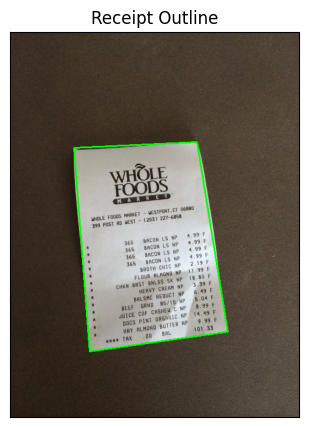

In [20]:
output = image.copy()
cv2.drawContours(output, [receiptCnt], -1, (0, 255, 0), 2)
plt_imshow("Receipt Outline", output)

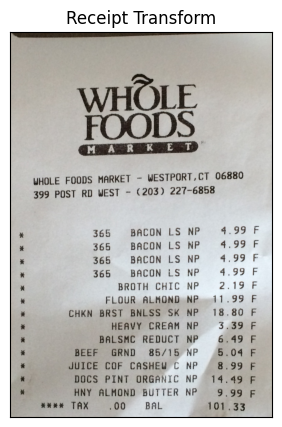

In [21]:
# 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
receipt = four_point_transform(org_image, receiptCnt.reshape(4, 2) * ratio)
plt_imshow("Receipt Transform", receipt)

-psm: page segmentation mode
 - --psm 4	**하나의 열(column)**만 있는 문서 (예: 영수증, 간단한 표 등)에 적합


In [22]:
options = "--psm 4"
text = pytesseract.image_to_string(cv2.cvtColor(receipt, cv2.COLOR_BGR2RGB), config=options)
print(text)

 

WHOLE
FOODS

WHOLE FOODS MARKET - WESTPORT, CT 06880
399 POST RD WEST - (203) 227-6858

365 BACON LS NP 4.99

365 BACON LS NP 4.99

365 BACON LS NP 4,99

365 BACON LS NP 4.99
BROTH CHIC NP 4.15

FLOUR ALMOND NP 11.99

CHKN BRST BNLSS SK NP 18.80
HEAVY CREAM NP 3.39

BALSMC REDUCT NP 6.49

BEEF GRND 85/15 NP 5.04
JUICE COF CASHEW C NP 8.99
DOCS PINT ORGANIC NP 14.49
HNY ALMOND BUTTER NP 9.99
eee TAX .00 BAL 101.33



In [23]:
# 정규식을 이용하여 가격이 포함된 Line 추출
pricePattern = r'([0-9]+\.[0-9]+)'
for row in text.split("\n"):
	if re.search(pricePattern, row) is not None:
		print(row)

365 BACON LS NP 4.99
365 BACON LS NP 4.99
365 BACON LS NP 4.99
BROTH CHIC NP 4.15
FLOUR ALMOND NP 11.99
CHKN BRST BNLSS SK NP 18.80
HEAVY CREAM NP 3.39
BALSMC REDUCT NP 6.49
BEEF GRND 85/15 NP 5.04
JUICE COF CASHEW C NP 8.99
DOCS PINT ORGANIC NP 14.49
HNY ALMOND BUTTER NP 9.99
eee TAX .00 BAL 101.33


- 하나의 함수로 생성: 입력은 opecv 기본 이미지 포맷BGR

In [24]:
def make_scan_image(image, width, ksize=(5,5), min_threshold=75, max_threshold=200):
  image_list_title = []
  image_list = []

  org_image = image.copy()
  image = imutils.resize(image, width=width)
  ratio = org_image.shape[1] / float(image.shape[1])

  # 이미지를 grayscale로 변환하고 blur를 적용
  # 모서리를 찾기위한 이미지 연산
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, ksize, 0)
  edged = cv2.Canny(blurred, min_threshold, max_threshold)

  image_list_title = ['gray', 'blurred', 'edged']
  image_list = [gray, blurred, edged]

  # contours를 찾아 크기순으로 정렬
  cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

  findCnt = None

  # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
  for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    # contours가 크기순으로 정렬되어 있기때문에 제일 첫번째 사각형을 영역으로 판단하고 break
    if len(approx) == 4:
      findCnt = approx
      break


  # 만약 추출한 윤곽이 없을 경우 오류
  if findCnt is None:
    raise Exception(("Could not find outline."))


  output = image.copy()
  cv2.drawContours(output, [findCnt], -1, (0, 255, 0), 2)

  image_list_title.append("Outline")
  image_list.append(output)

  # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
  transform_image = four_point_transform(org_image, findCnt.reshape(4, 2) * ratio)

  plt_imshow(image_list_title, image_list)
  plt_imshow("Transform", transform_image)

  return transform_image

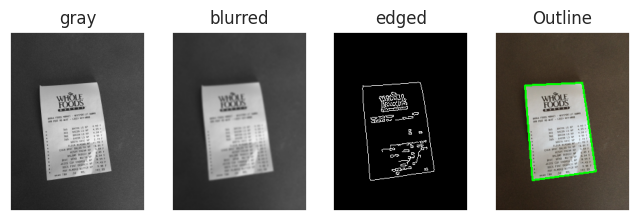

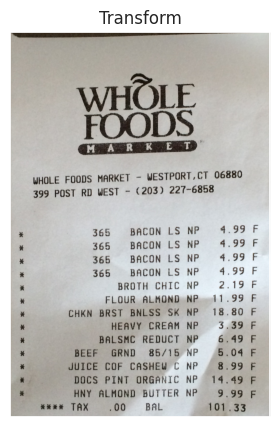

In [88]:
receipt_image = make_scan_image(org_image, width=200)

- 수정된 이미지를 OCR 수행

In [26]:
options = "--psm 4"
text = pytesseract.image_to_string(cv2.cvtColor(receipt_image, cv2.COLOR_BGR2RGB), config=options)

# OCR결과 출력
print(text)

 

WHOLE
FOODS

WHOLE FOODS MARKET - WESTPORT, CT 06880
399 POST RD WEST ~- (203) 227-6858

365 BACON LS NP 4.99

365 BACON LS NP 4.99

365 BACON LS NP 99

365 BACON LS NP 4.99
BROTH CHIC NP rae

FLOUR ALMOND NP 11.99

CHKN BRST BNLSS SK NP 18.80
HEAVY CREAM NP 3.39

BALSMC REDUCT NP 6.49

BEEF GRND 85/15 NP 5.04
JUICE COF CASHEW C NP 8.99
DOCS PINT ORGANIC NP 14.49
HNY ALMOND BUTTER NP 9.99
eee TAX .00 BAL 101.33



- 전화번호만 추출

In [27]:
phoneNums = re.findall(r'[\+\(]?[1-9][0-9 .\-\(\)]{8,}[0-9]', text)
phoneNums

['(203) 227-6858']

- 가격만 추출

In [28]:
prices = re.findall(r"(?:NP )([0-9\.\-+_]+\.[0-9\.\-+_]+)", text)
prices

['4.99',
 '4.99',
 '4.99',
 '11.99',
 '18.80',
 '3.39',
 '6.49',
 '5.04',
 '8.99',
 '14.49',
 '9.99']

- 합산 가격 추출

In [29]:
total_price = re.findall(r"(?:BAL )([0-9\.\-+_]+\.[0-9\.\-+_]+)", text)
total_price

['101.33']

- Regular expression
 - re.search(pattern, string)	문자열에서 처음 매치되는 부분을 반환
 - re.match(pattern, string)	문자열의 시작 부분이 패턴과 매치되는지 확인
 - re.findall(pattern, string)	문자열에서 패턴과 일치하는 모든 부분 리스트로 반환
 - re.finditer(pattern, string)	일치하는 모든 부분을 이터레이터 객체로 반환
 - re.sub(pattern, repl, string)	패턴을 repl로 치환
 - re.split(pattern, string)	패턴을 기준으로 문자열 분리

In [30]:
import re

text = "문의: test@example.com, backup: info@domain.co.kr"
emails = re.findall(r'\b[\w.-]+@[\w.-]+\.\w+\b', text)
print(emails)
# 결과: ['test@example.com', 'info@domain.co.kr']

['test@example.com', 'info@domain.co.kr']


In [31]:
text = "주문번호: 12345, 가격: 89,000원"
numbers = re.findall(r'\d+', text)
print(numbers)
# 결과: ['12345', '89', '000']

['12345', '89', '000']


In [32]:
text = "제조 데이터 제조"
cleaned = re.sub(r'제조', '**', text)
print(cleaned)


** 데이터 **


In [33]:
pattern = re.compile(r'\d+')    #빠르게 패턴 발견
result = pattern.findall("전화번호: 010-1234-5678")
print(result)
# 결과: ['010', '1234', '5678']

['010', '1234', '5678']


In [34]:
text = "이름: 김철수, 나이: 25세"
match = re.search(r'이름:\s*(\w+),\s*나이:\s*(\d+)', text)
if match:
    print(match.group(1))  # 김철수
    print(match.group(2))  # 25

김철수
25


#2. Chart+OCR

In [35]:
!wget https://raw.githubusercontent.com/ws-l/hh2025/main/data/img.zip

--2025-05-25 20:43:27--  https://raw.githubusercontent.com/ws-l/hh2025/main/data/img.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 359869 (351K) [application/zip]
Saving to: ‘img.zip’

img.zip             100%[===================>] 351.43K  --.-KB/s    in 0.007s  

2025-05-25 20:43:27 (51.0 MB/s) - ‘img.zip’ saved [359869/359869]



In [36]:
!mkdir img
!mv img.zip img

In [37]:
!cd img && unzip img.zip

Archive:  img.zip
  inflating: image_10.png            
  inflating: image_1.png             
  inflating: image_2.png             
  inflating: image_3.png             
  inflating: image_4.png             
  inflating: image_5.png             
  inflating: image_6.png             
  inflating: image_7.png             
  inflating: image_8.png             
  inflating: image_9.png             


In [38]:
import pytesseract
import cv2
from pytesseract import Output
import matplotlib.pyplot as plt

img = cv2.imread("img/image_4.png")
d = pytesseract.image_to_data(img, output_type=Output.DICT)

n_boxes = len(d['text'])
n_boxes

33

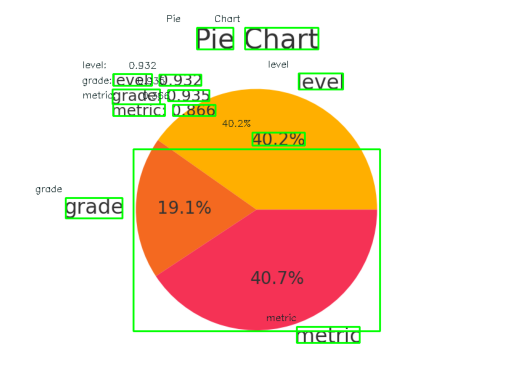

In [39]:
for i in range(n_boxes):
    if int(d['conf'][i]) > 50:  #신뢰도 50이상인 텍스트 박스만 대상
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        text = d['text'][i]
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        img = cv2.putText(img, text, (x-50, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,35,12), 1)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

#3. 탐색적 데이터 분석

### 1. 통계량과 탐색

1) 데이터 읽기

In [40]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns

data = pd.read_csv("https://raw.githubusercontent.com/ws-l/hh2025/main/data/creditset2.csv")
data.describe()

,income,age,loan,default10yr
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,45331.600018,40.927143,4444.369695,0.141500
std,14326.327119,13.262450,3045.410024,0.348624
min,20014.489470,18.055189,1.377630,0.000000
25%,32796.459720,29.062492,1939.708847,0.000000
50%,45789.117310,41.382673,3974.719418,0.000000
75%,57791.281670,52.596993,6432.410625,0.000000
max,69995.685580,63.971796,13766.051240,1.000000


2) 공분산

In [42]:
import numpy as np
import scipy as sp

data[["age", "income"]].cov()

,age,income
age,175.892573,-6.647007e+03
income,-6647.007133,2.052436e+08


3) 상관관계

In [43]:
import numpy as np
from scipy import stats

data[["age", "income", "loan"]].corr()

,age,income,loan
age,1.000000,-0.034984,0.006561
income,-0.034984,1.000000,0.441117
loan,0.006561,0.441117,1.000000


4) df+시각화

<Axes: >

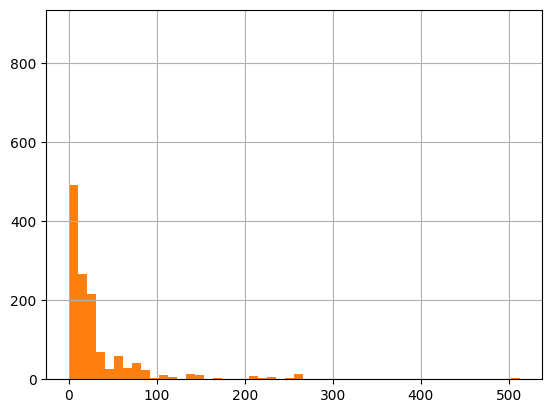

In [45]:
#탐색적 자료 분석
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('https://raw.githubusercontent.com/ws-l/hh2025/main/data/titanic.csv')
data.columns
data.dtypes
data['sibsp'].unique()
data['fare'].unique()[0:20]

#embarked, cabin에 대해서도 확인해보기
data['embarked'].unique()
#data.describe()
#Histogram
data['sibsp'].hist(bins=20)
data['fare'].hist(bins=50)

6) seaborn 활용 탐색

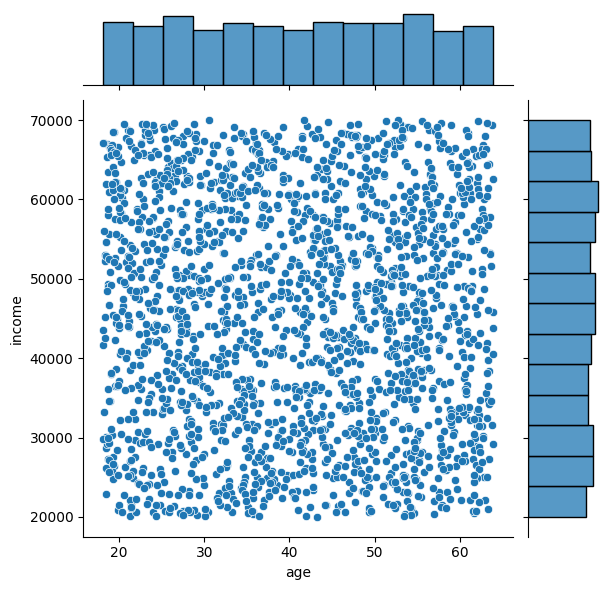

In [46]:
#seaborn 활용 시각화 연습
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = pd.read_csv("https://raw.githubusercontent.com/ws-l/hh2025/main/data/creditset2.csv")
join1 = sns.jointplot(x="age", y="income", data=data);
join1.savefig("join1.png")


In [47]:
#tips 예제 데이터로 연습
plt.clf()

tips = sns.load_dataset('tips')
sns.set_style("whitegrid")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


<Figure size 640x480 with 0 Axes>

- tips 데이터에서, time별로 total_bill의 박스플랏
- 각 boxplot은 성별로 나눠서 표현 (hue를 지정)

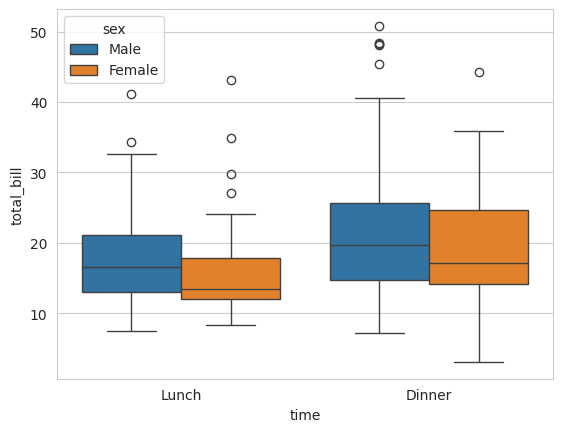

In [48]:
#box plot
#sns.boxplot(x="sex", y="total_bill", data=tips)
#plt.show()

#box plot
sns.boxplot(x="time", y="total_bill", hue="sex", data=tips)
plt.show()

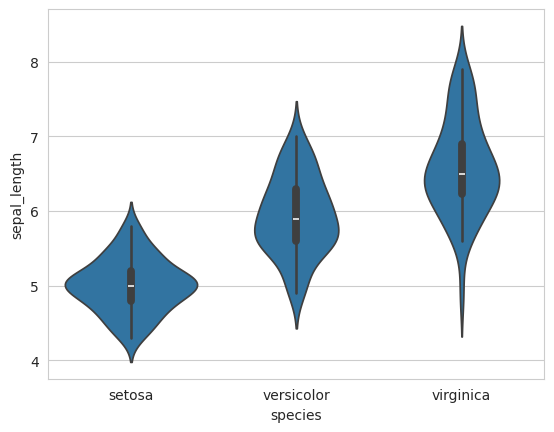

In [49]:
#violin plot
iris = sns.load_dataset("iris")
sns.violinplot(x=iris.species, y=iris.sepal_length, data=iris);
plt.savefig("violin.png")

In [50]:
#pivot+Heatmap
#pivot
df1 = pd.DataFrame( {'x':['A','B', 'C', 'D', 'E', 'F'], 'y':[2021,2021,2021,2022,2022,2022], 'z':[1,2,3,4,5,6]})
df1.pivot(index='x',columns='y', values='z').fillna(0) #index 중복 없어야 함.

y,2021,2022
x,,
A,1.0,0.0
B,2.0,0.0
C,3.0,0.0
D,0.0,4.0
E,0.0,5.0
F,0.0,6.0


In [53]:
flights = sns.load_dataset("flights")
flights.head()

df = flights.pivot(index='month', columns='year', values='passengers')
df.head()

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
Jan,112,115,145,171,196,204,242,284,315,340,360,417
Feb,118,126,150,180,196,188,233,277,301,318,342,391
Mar,132,141,178,193,236,235,267,317,356,362,406,419
Apr,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472


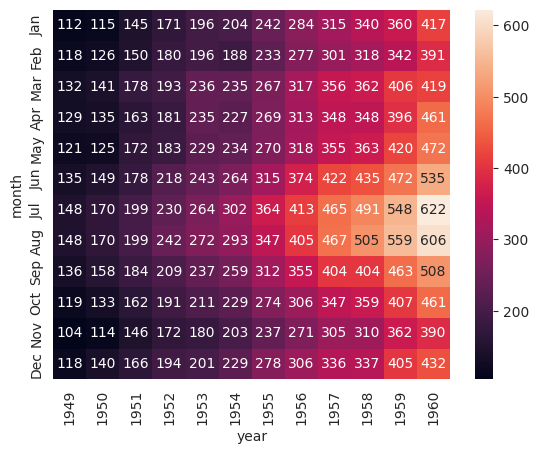

In [54]:
#heatmap
sns.heatmap( df , annot=True, fmt="d")	#fmt='d' 정수형태로 수치 입력
plt.show()

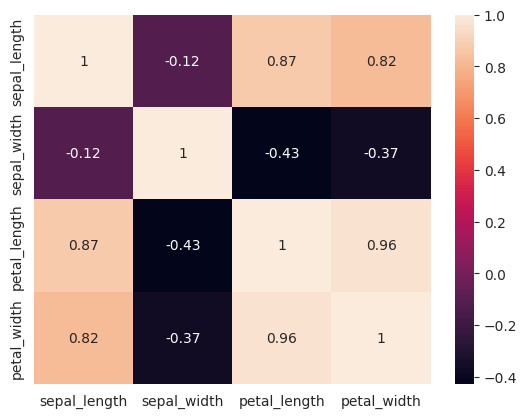

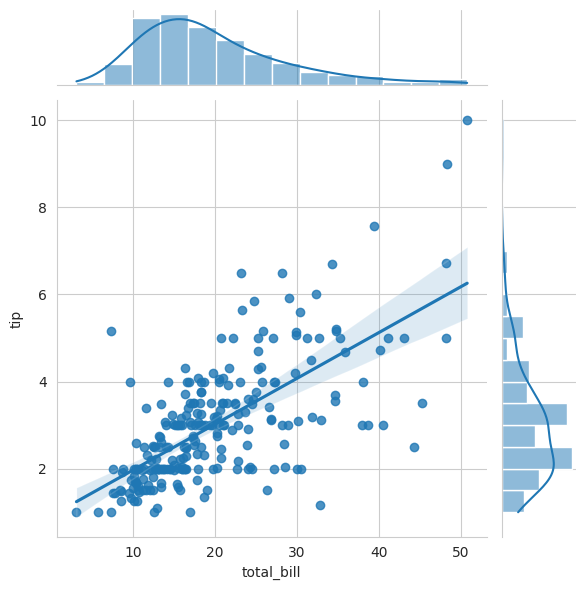

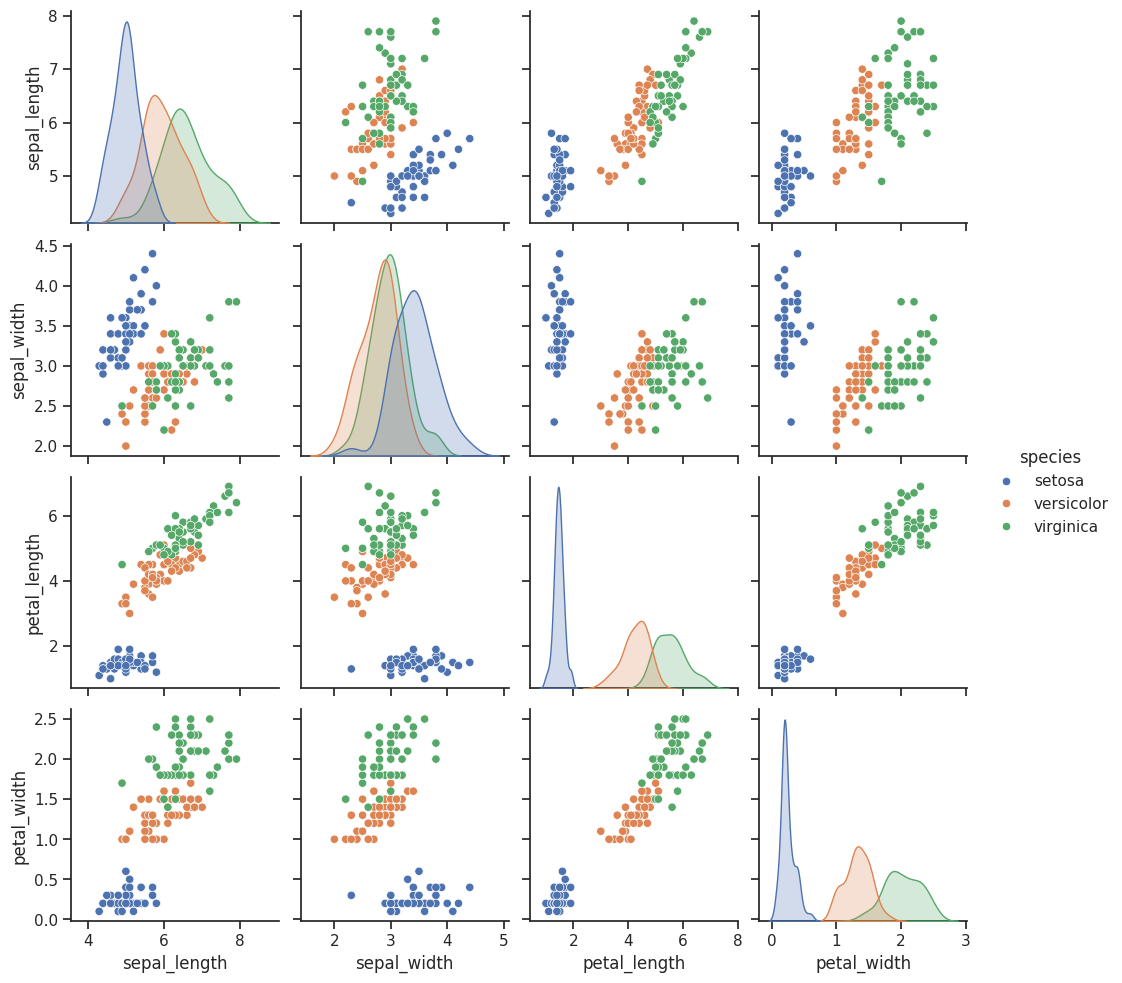

In [57]:
#heatmap+pandas
df.style.background_gradient(cmap='summer')

#heatmap+corr
corr=iris.iloc[:,0:4].corr()
corr
sns.heatmap(corr, annot=True)

#jointplot
sns.jointplot(x="total_bill", y="tip", data=tips, kind="reg");
plt.savefig('join3.png')

#pair plot
sns.set(style="ticks")
iris = sns.load_dataset("iris")
iris.head(10)

sns.pairplot(iris, hue="species")
plt.show()

<Axes: xlabel='timepoint', ylabel='signal'>

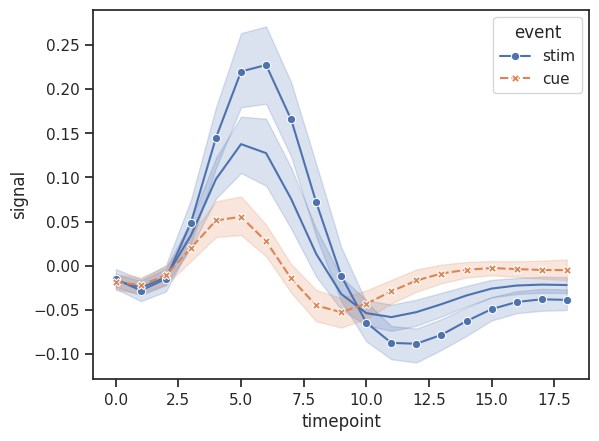

In [58]:
#line plot
fmri = sns.load_dataset("fmri")
fmri.head()

sns.lineplot(x="timepoint", y="signal", data=fmri)
sns.lineplot(x="timepoint", y="signal", hue="event", style="event", markers=True, data=fmri)

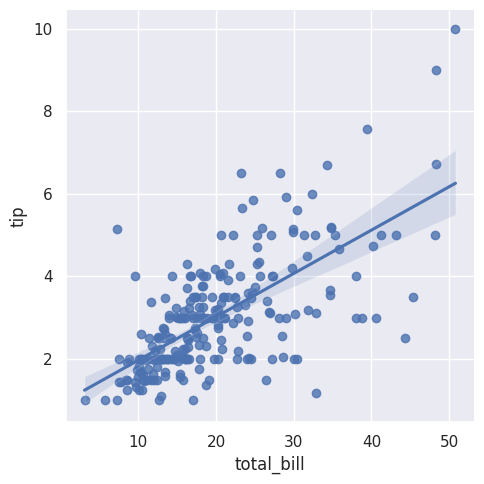

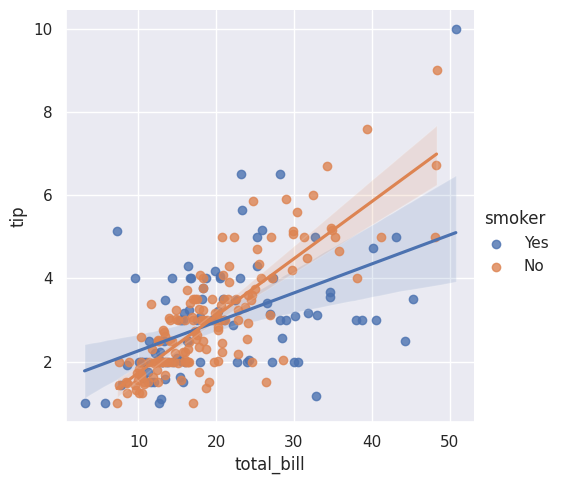

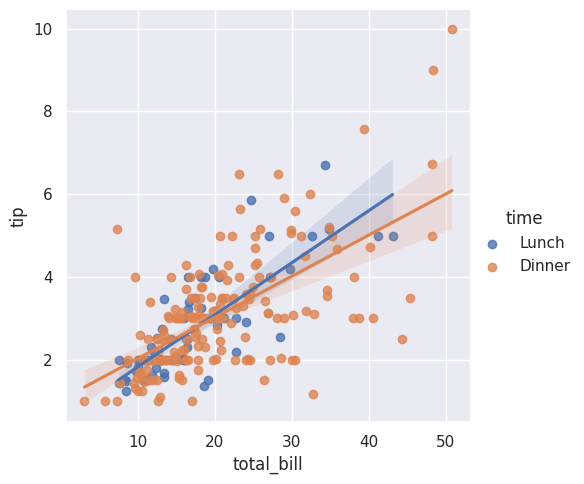

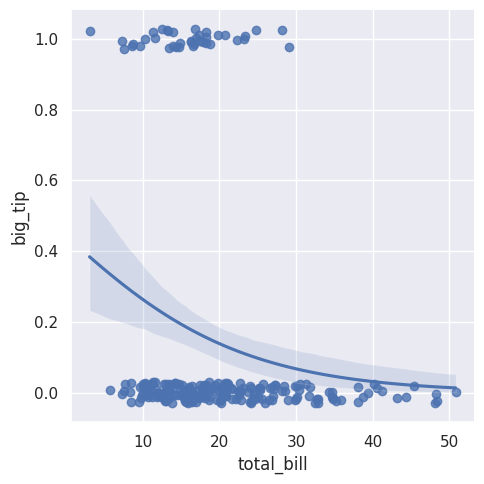

In [59]:
#lm plot
sns.set_style("darkgrid")
sns.lmplot( x="total_bill", y="tip", data=tips)
plt.show()

#lm plot
sns.set_style("darkgrid")
sns.lmplot( x="total_bill", y="tip", data=tips, hue="smoker")
plt.show()

#lm plot
sns.set_style("darkgrid")
sns.lmplot( x="total_bill", y="tip", data=tips, hue="time")
plt.show()

#logistic regression 결과, binary 표시(20%기준)
tips['big_tip'] = tips['tip']/tips['total_bill'] >= 0.2
sns.lmplot(x="total_bill", y="big_tip", data=tips,logistic=True, y_jitter=.03);
plt.savefig("tiplogit.png")


###2. 범주형 변수 탐색

In [60]:
#범주를 순서로 치환
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

data = pd.read_csv('https://raw.githubusercontent.com/ws-l/hh2025/main/data/creditApprovalUCI.csv')
X_train, X_test, y_train, y_test = train_test_split(data.drop(labels=['A16'], axis=1), data['A16'],test_size=0.3,random_state=0)

#A7을 실습해보기
ordinal_mapping = {k: i for i, k in enumerate(X_train['A7'].unique(), 0) }
ordinal_mapping
#범주가 순서로 변경
X_train['A7'] = X_train['A7'].map(ordinal_mapping)
X_test['A7'] = X_test['A7'].map(ordinal_mapping)
X_train['A7']

#sklearn
vars_categorical = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10','A12', 'A13']

le = OrdinalEncoder()
le.fit(X_train[vars_categorical])

X_train_enc = le.transform(X_train[vars_categorical])
X_test_enc = le.transform(X_test[vars_categorical])
X_train_enc

array([[0., 1., 0., ..., 1., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 2., 2., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 1., 0.],
       [1., 1., 0., ..., 0., 1., 2.]])

In [61]:
#범주형 변수의 범주값을 범주의 빈도 등으로 교체
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('https://raw.githubusercontent.com/ws-l/hh2025/main/data/creditApprovalUCI.csv')
X_train, X_test, y_train, y_test = train_test_split(data.drop(labels=['A16'], axis=1), data['A16'],test_size=0.3, random_state=0)
count_map = X_train['A7'].value_counts().to_dict()
count_map

{'v': 277,
 'h': 101,
 'ff': 41,
 'bb': 39,
 'z': 7,
 'dd': 5,
 'j': 5,
 'n': 3,
 'o': 1}

In [62]:
#빈도 대신 비율인 경우
frequency_map = (X_train['A6'].value_counts() / len(X_train) ).to_dict()
#변수에 반영
X_train['A7'] = X_train['A7'].map(count_map)
X_test['A7'] = X_test['A7'].map(count_map)

#여러 특정 변수에 적용
def count_mappings(df, variable):
	return df[variable].value_counts().to_dict()
def frequency_mappings(df, variable):
	return (df[variable].value_counts() / len(df)).to_dict()
def encode(train, test, variable, mapping):
	X_train[variable] = X_train[variable].map(mapping)
	X_test[variable] = X_test[variable].map(mapping)


In [63]:
vars_categorical = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']

for variable in vars_categorical:
	mappings = count_mappings(X_train, variable)
	encode(X_train, X_test, variable, mappings)

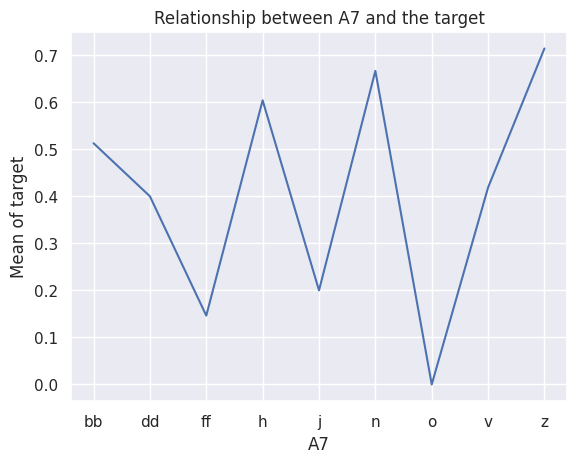

In [64]:
#범주를 순서대로 인코딩
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

data = pd.read_csv('https://raw.githubusercontent.com/ws-l/hh2025/main/data/creditApprovalUCI.csv')
X_train, X_test, y_train, y_test = train_test_split(data, data['A16'], test_size=0.3, random_state=0)
X_train.groupby(['A7'])['A16'].mean().plot()
plt.title('Relationship between A7 and the target')
plt.ylabel('Mean of target')
plt.show()



Index(['o', 'ff', 'j', 'dd', 'v', 'bb', 'h', 'n', 'z'], dtype='object', name='A7')


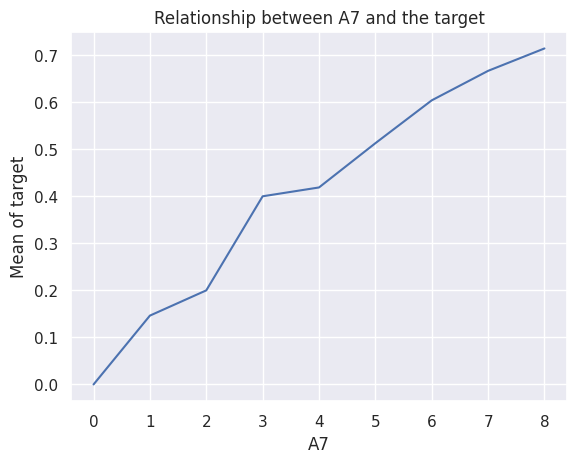

In [65]:
#범주별 평균 구하기
ordered_labels =X_train.groupby(['A7'])['A16'].mean().sort_values().index
print(ordered_labels)

ordinal_mapping = {k: i for i, k in enumerate(ordered_labels, 0)}
X_train['A7'] = X_train['A7'].map(ordinal_mapping)
X_test['A7'] = X_test['A7'].map(ordinal_mapping)

X_train.groupby(['A7'])['A16'].mean().plot()
plt.title('Relationship between A7 and the target')
plt.ylabel('Mean of target')
plt.show()

In [66]:
#rare, infrequent 범주 그룹화
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('https://raw.githubusercontent.com/ws-l/hh2025/main/data/creditApprovalUCI.csv')
X_train, X_test, y_train, y_test = train_test_split(data.drop(labels=['A16'], axis=1), data['A16'],test_size=0.3,random_state=0)
temp = X_train['A7'].value_counts() / len(X_train)

temp[temp>0.05]
#5%미만을 rare 범주로 변경
def find_frequent_labels(df, variable, tolerance):
	temp = df[variable].value_counts() / len(df)
	frequent = [x for x in temp.loc[temp>tolerance].index.values]
	return frequent

frequent_cat = find_frequent_labels(X_train, 'A7', 0.05)
frequent_cat
X_train['A7'] = np.where(X_train['A7'].isin(frequent_cat), X_train['A7'], 'Rare')
X_test['A7'] = np.where(X_test['A7'].isin(frequent_cat), X_test['A7'], 'Rare')

X_train['A7'].value_counts() / len(X_train)

,count
A7,
v,0.573499
h,0.209110
ff,0.084886
bb,0.080745
Rare,0.051760


In [67]:
pd.DataFrame(['a', 'b', 'c','a', 'c']).isin(['a', 'b'])

,0
0,True
1,True
2,False
3,True
4,False
